In [1]:
from soursop.sstrajectory import SSTrajectory
import mdtraj as md
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

import matplotlib
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

# define this so we can read in nucleotides
NA_EXTENSION = ['D5P', 'DPC',  'DPU',  'DPT',  'DPA',  'DPG',  'R5P',  'RPC' , 'RPU',  'RPT',  'RPA',  'RPG']




## Define functions
The code below defines the functions we're going to use in this notebook.

In [2]:
# ......................................................
#
def build_traces(COM_distances, bound_length, cutoff):
    """
    Function that assesses bound and unbound states based on contigous stretches of
    the simulation where the centers of mass are conistently below some threshold.
    
    In particular, $bound_length defines the number of consecutive frames which must 
    be below some threshold for a simulation to be considered bound. $cutoff defines what
    this distance threshold is. For example, if bound_length=20 (default) we only consider
    regions of the inter-molecular COM distance. 
    
    Parameters
    -------------
    COM_distances : np.ndarray
        Array of inter-molecular center of mass (COM) distances. Expect one value
        per frame.
        
    bound_length : int
        Number of consecutive frames required to designate an interaction as 'bound'
        
    cutoff : float
        Distance (in Angstroms) used to define if two molecules are bound or not. Note
        this is the COM distance, not the minimum contact distance (!).
        
        
    Returns
    -----------
    tuple
        Returns a tuple with three elements
        
        # fraction bound
        [0] - float      - the fraction bound of this simulation
        
        # bound_trace
        [1] - np.ndarray - shape=(2,n), where the two columns are the
                           index of a bound frame and the distance in 
                           that frame
                           
        # unbound_trace
        [2] - np.ndarray - shape=(2,n), where the two columns are the
                           index of a bound frame and the distance in 
                           that frame
    
    """

    # initialize some variables
    bound_trace = []
    unbound_trace = []
    inside = False

    all_bound_idx = set([])
    all_unbound_idx = set([])

    idx = bound_length-1
    
    # cycle over the bound_length-thed index to the end of
    # the COM array
    for idx in range(bound_length, len(COM_distance)):

        # get the distance at the idx position
        i = COM_distance[idx]

        # define the preceding bound_length-sized set of
        # frames (i.e. the 'history' is the set frames
        # that come $bound_length before the current 
        # index
        history = COM_distance[idx-bound_length:idx]

        # if we're already 'inside' a bound part of the
        # trajectory
        if inside:  
            
            # if under the cutoff then carry on, we've found
            # additional frames in a contigous set of frames 
            # that are bound
            if i < cutoff:            
                bound_trace.append([idx,i])
                all_bound_idx.add(idx)
                
            # if we're above the cutoff then this means an unbinding
            # event happens
            else:
                inside = False
                
        # if we're not currently inside a bound set of frames
        else:
            
            # if this frame is bound
            if i < cutoff:
                
                # if were the last set of frames all under the reshold
                if np.max(history) < cutoff:
                    
                    # if yes we're insidew
                    inside = True

                    for tmp_idx, tmp_i in enumerate(history):
                        local_idx = idx-(bound_length - tmp_idx)
                        bound_trace.append([local_idx, tmp_i])
                        all_bound_idx.add(local_idx)
                        
                    bound_trace.append([idx,i])
                    all_bound_idx.add(idx)


    # now, having classufued every frame, we can go through all the frames and 
    # if they're not in one of the all_bound_idx set they must be all unbound
    for idx in range(bound_length, len(COM_distance)):
        i = COM_distance[idx]
        if idx not in all_bound_idx:
            unbound_trace.append([idx,i])
            all_unbound_idx.add(idx)
        
    bound_trace = np.array(bound_trace).transpose()
    unbound_trace = np.array(unbound_trace).transpose()
    
    # calculate the fraction bound
    fraction_bound = len(all_bound_idx)/(len(all_unbound_idx)+len(all_bound_idx))
 
    return (fraction_bound, bound_trace, unbound_trace)





In [5]:
##
## This is the main analysis cell for this entire workbook!
##

# define range of RNA lengths we look at
RNA_lengths = [10, 15, 20, 25, 30, 35, 40]


# this defines the number of contigous frames below the bound cutoff we need to say a
# chain is in the bound state. 
bound_length = 5

# initialize some empty dicts
len2COM_distance = {}
len2COM_bound_trace = {}
len2COM_unbound_trace = {}

# len2cutoff define mapping between the bound/unbound cutoff as a function of RNA length. 
len2cutoff = {}
len2cutoff[10] = 42
len2cutoff[15] = 44
len2cutoff[20] = 46
len2cutoff[25] = 48
len2cutoff[30] = 50
len2cutoff[35] = 60
len2cutoff[40] = 65


# main loop - note this analysis for EVERYTHING actually only takes ~5-10 seconds (!!)
for RNA_len in RNA_lengths:
    
    # read in the COM trajectory that was previously built using the script
    # build_com_traj.py (also in this directory).
    
    CM_ss = SSTrajectory(f'../data/COM_trajectories/COM_{RNA_len}.xtc',f'../data/COM_trajectories/COM_{RNA_len}.pdb', extra_valid_residue_names=['CM'])
    
    # distances between COM in Angstoms
    COM_distance = CM_ss.get_interchain_distance(0,1,0,0)
    
    # get all the COM distances for the RNA of this length and save them in case
    # we want to plot later
    len2COM_distance[RNA_len] = COM_distance

    # calculate the fraction bound
    tmp = build_traces(COM_distance, cutoff=len2cutoff[RNA_len], bound_length=bound_length)
    
    
    fraction_bound = tmp[0]
    len2COM_bound_trace[RNA_len] = tmp[1]
    len2COM_unbound_trace[RNA_len] = tmp[2]
    


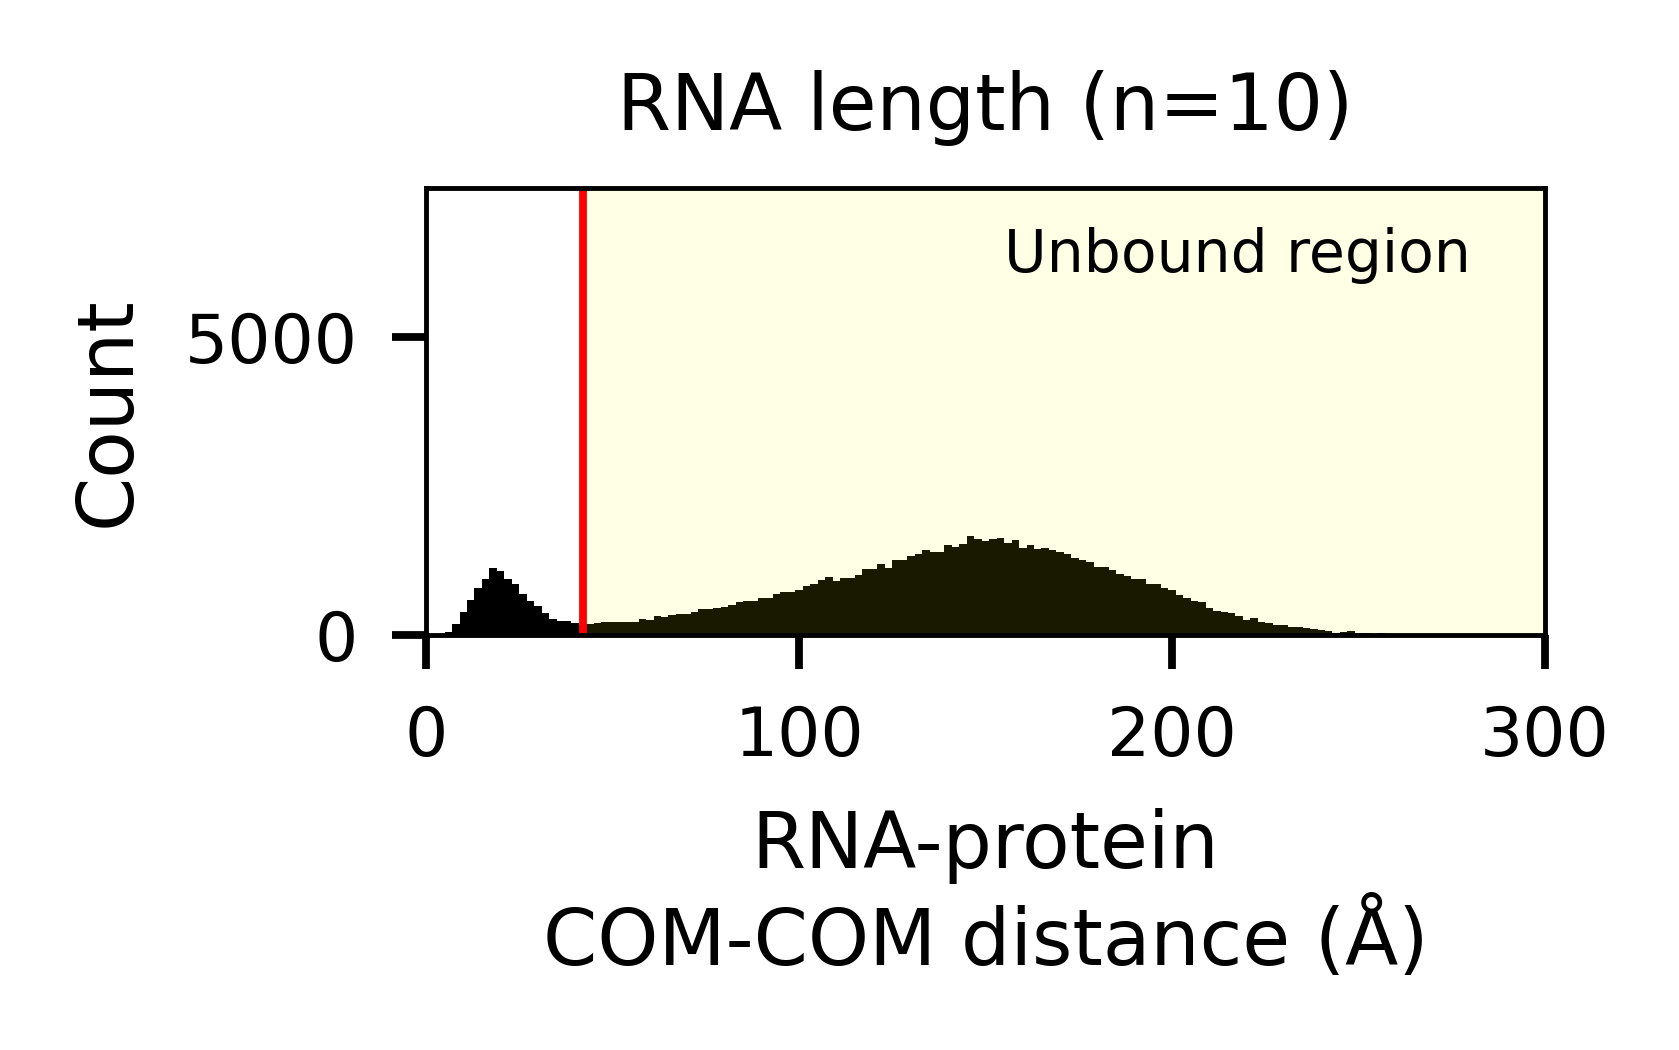

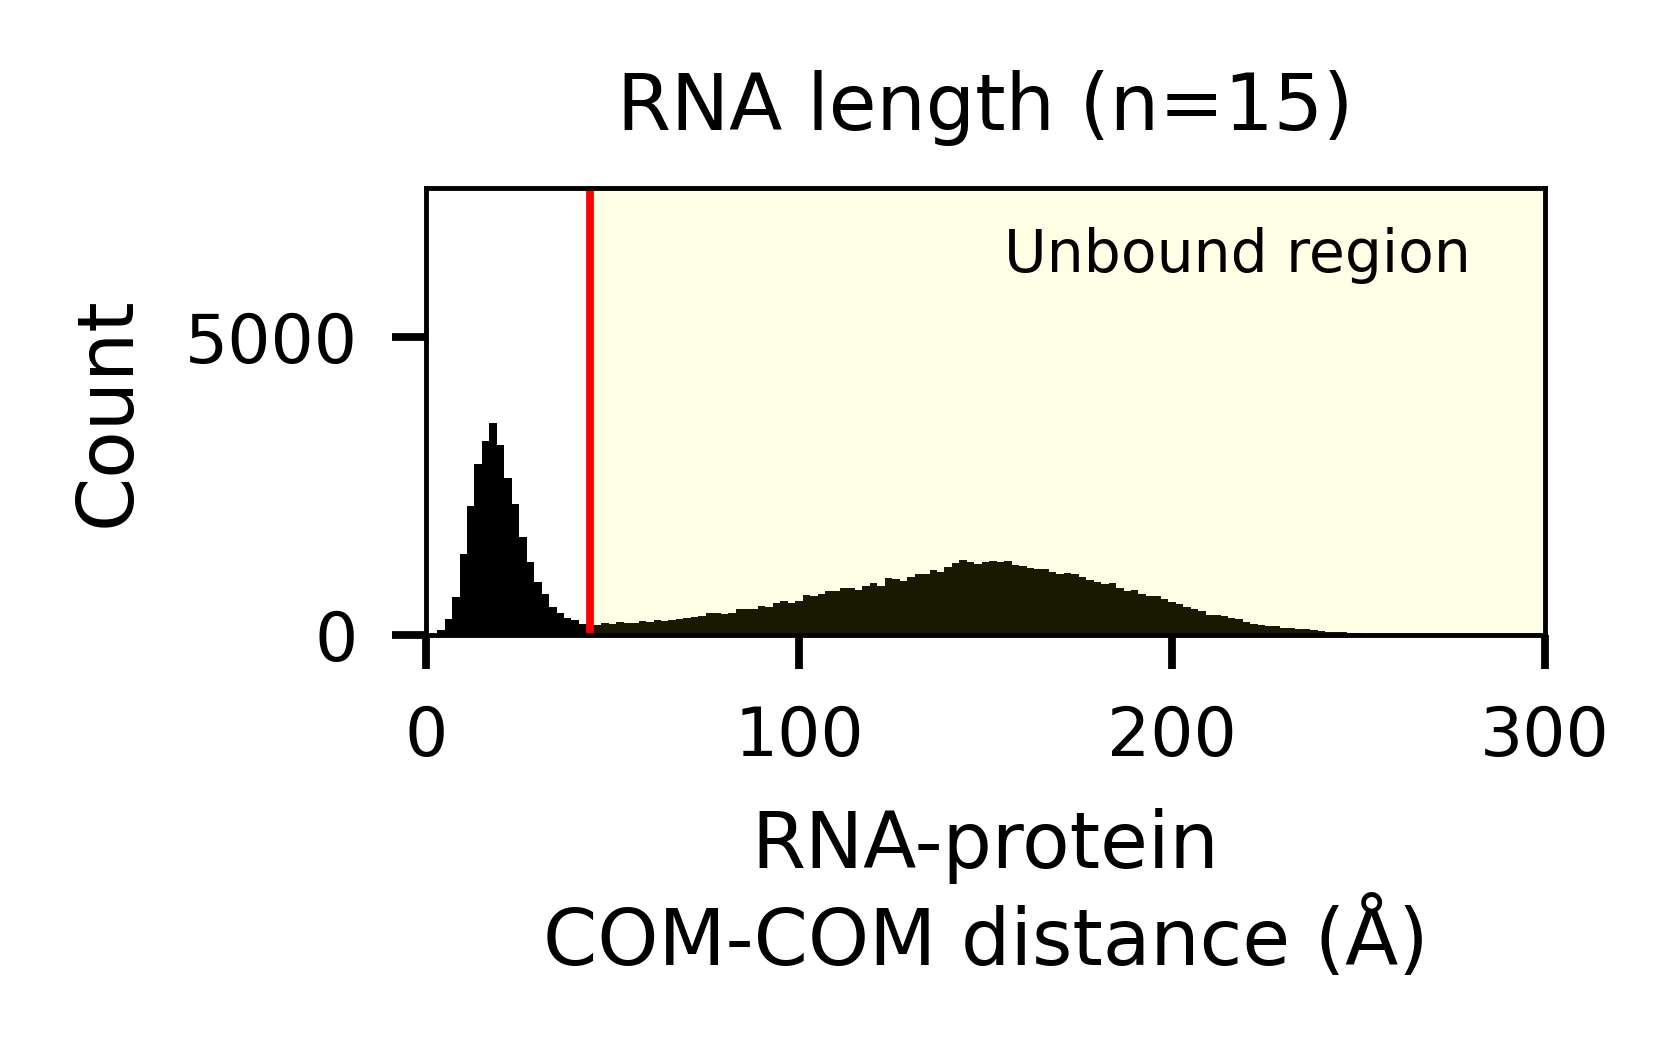

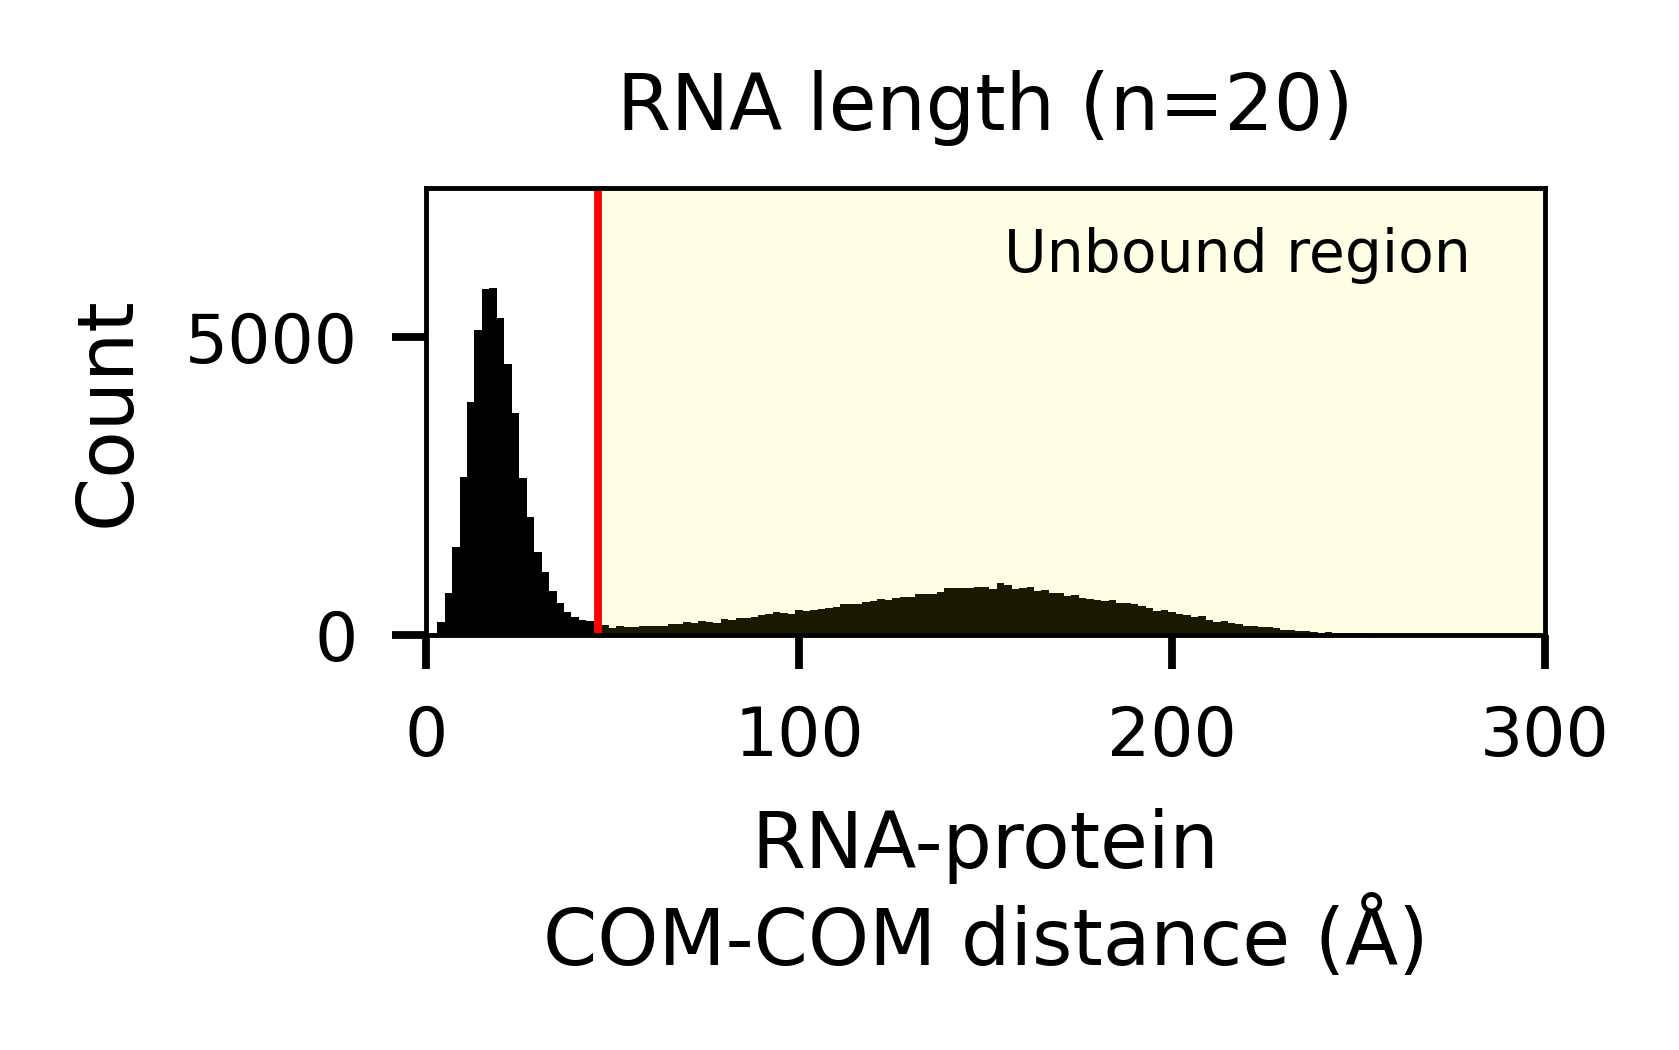

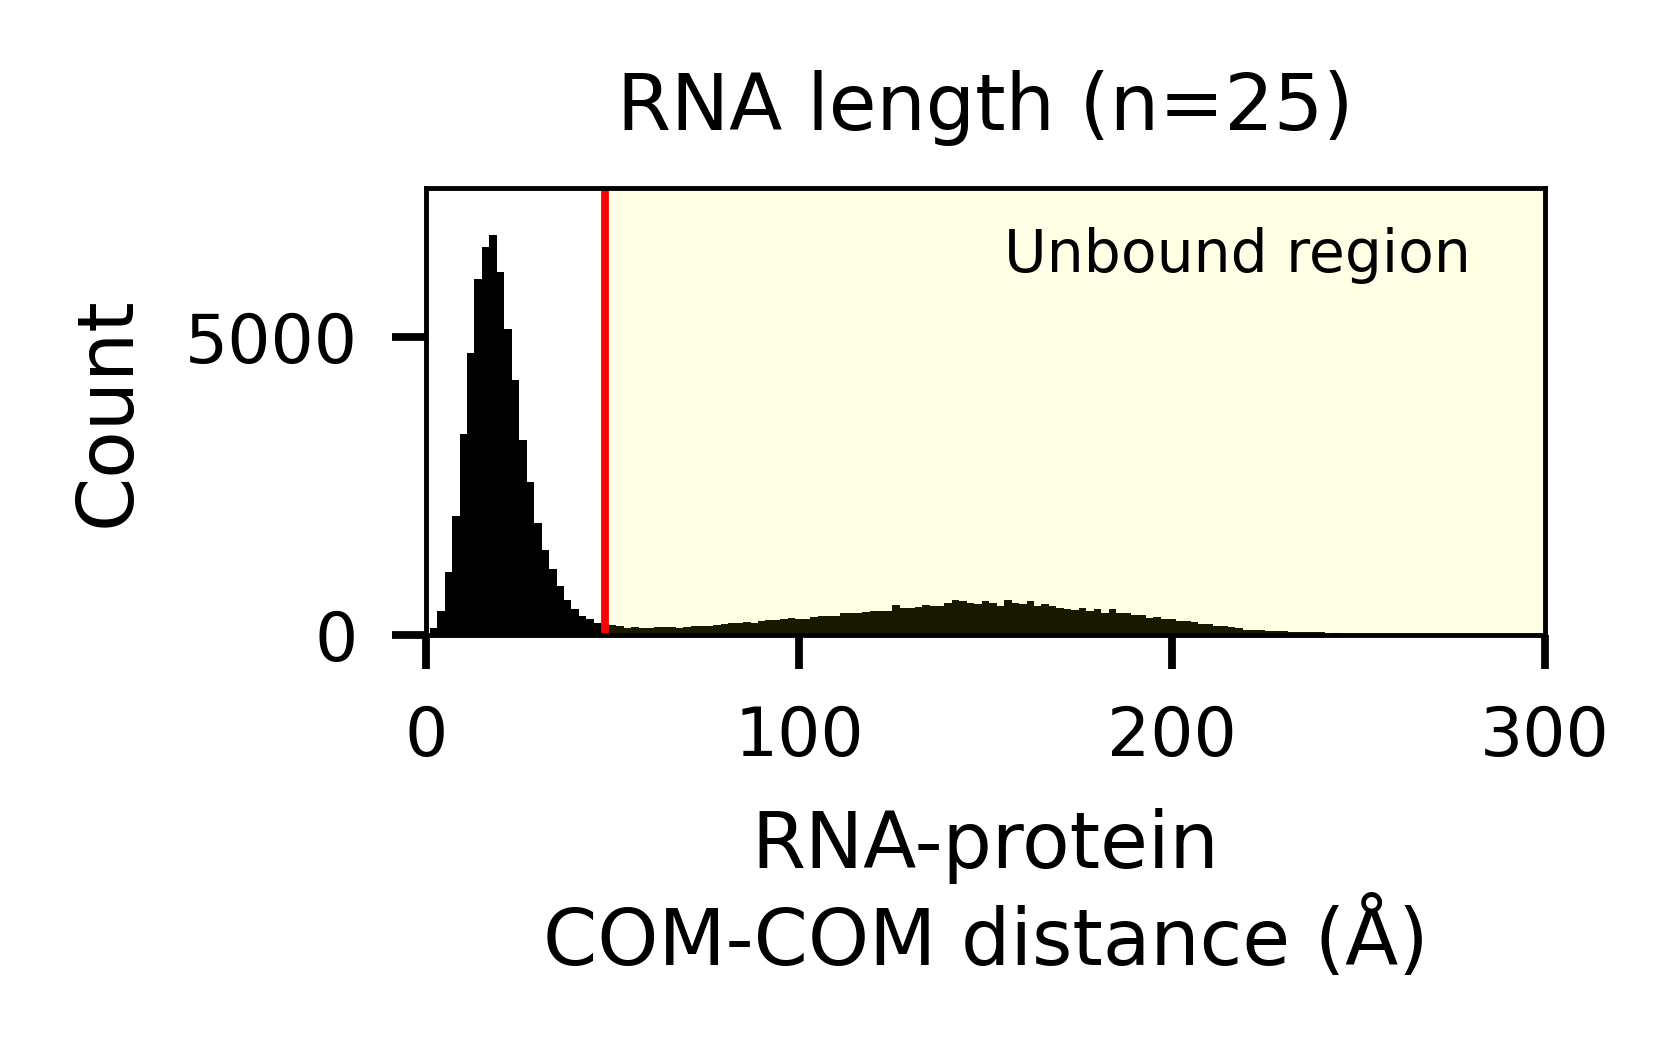

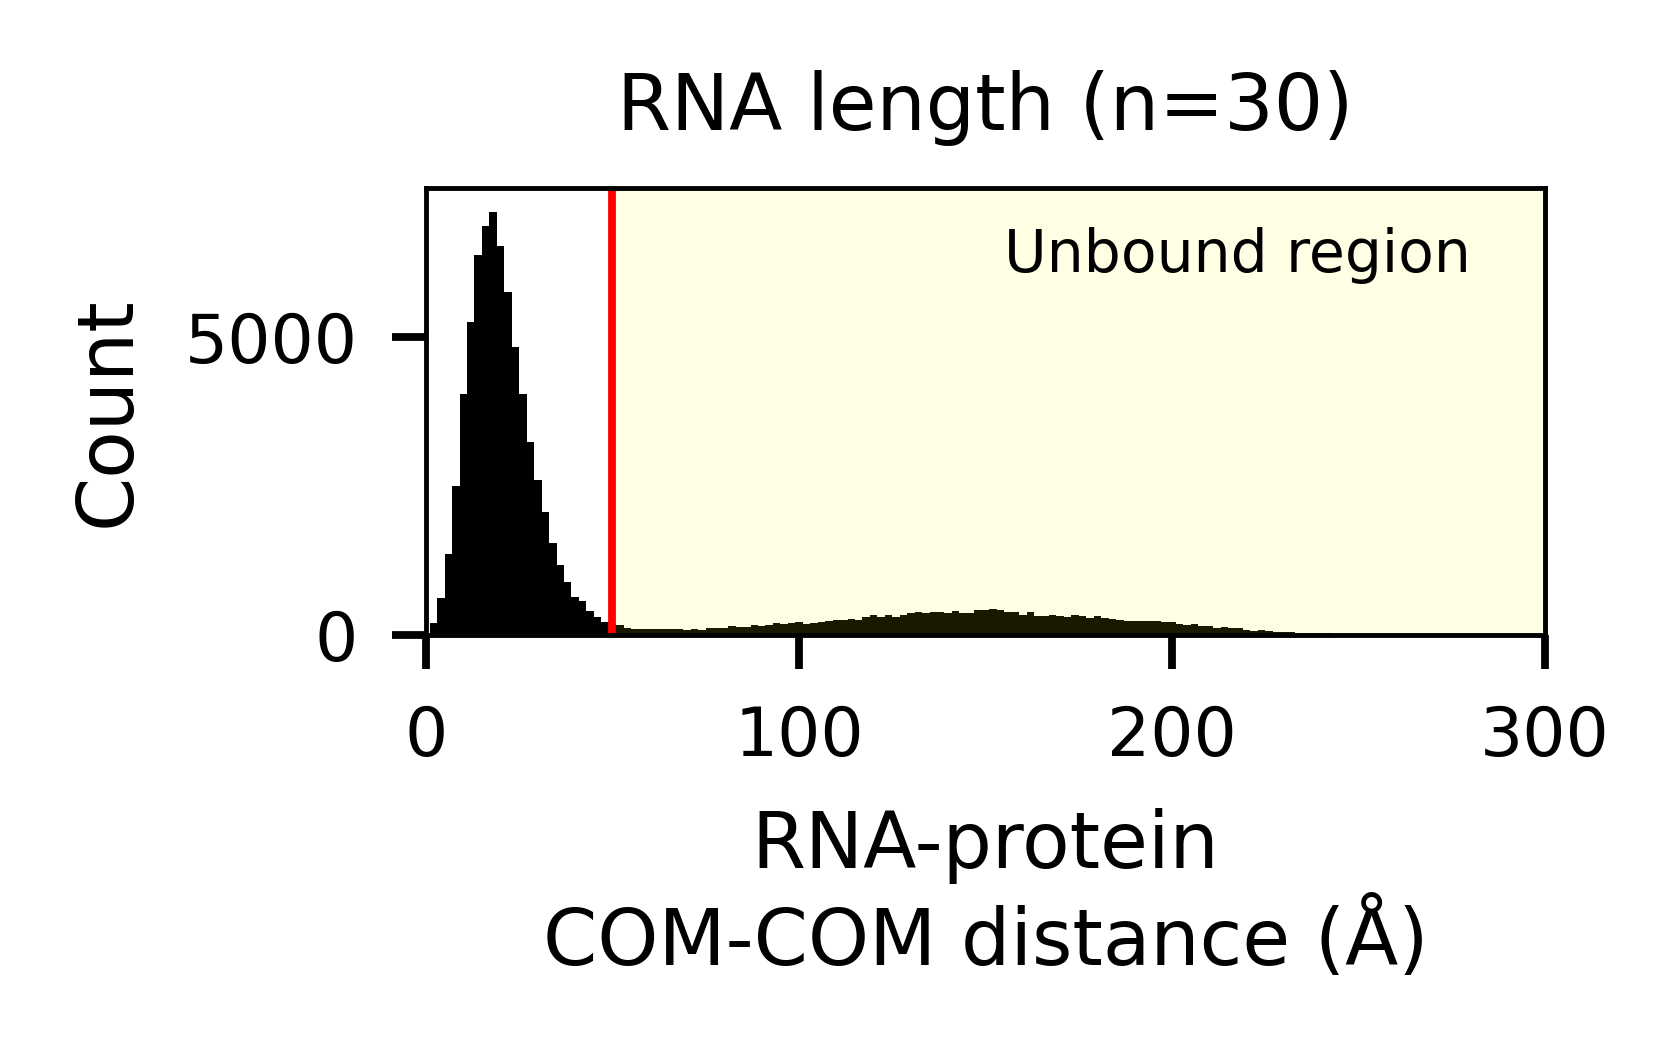

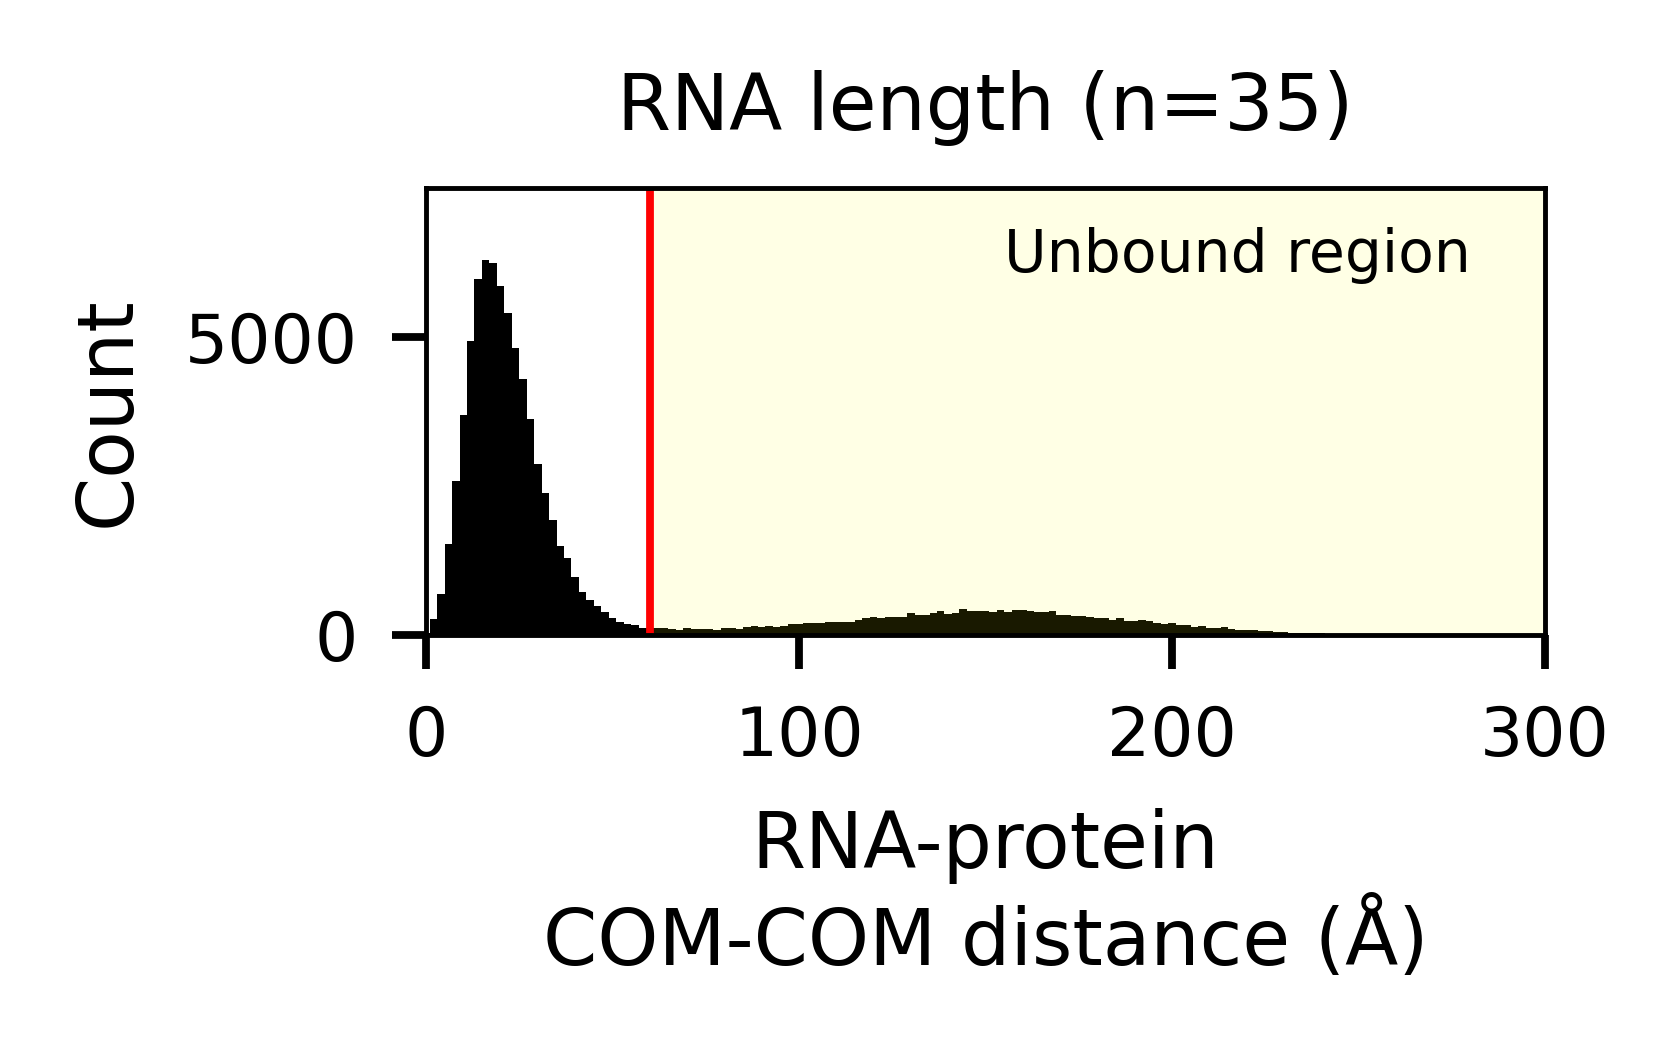

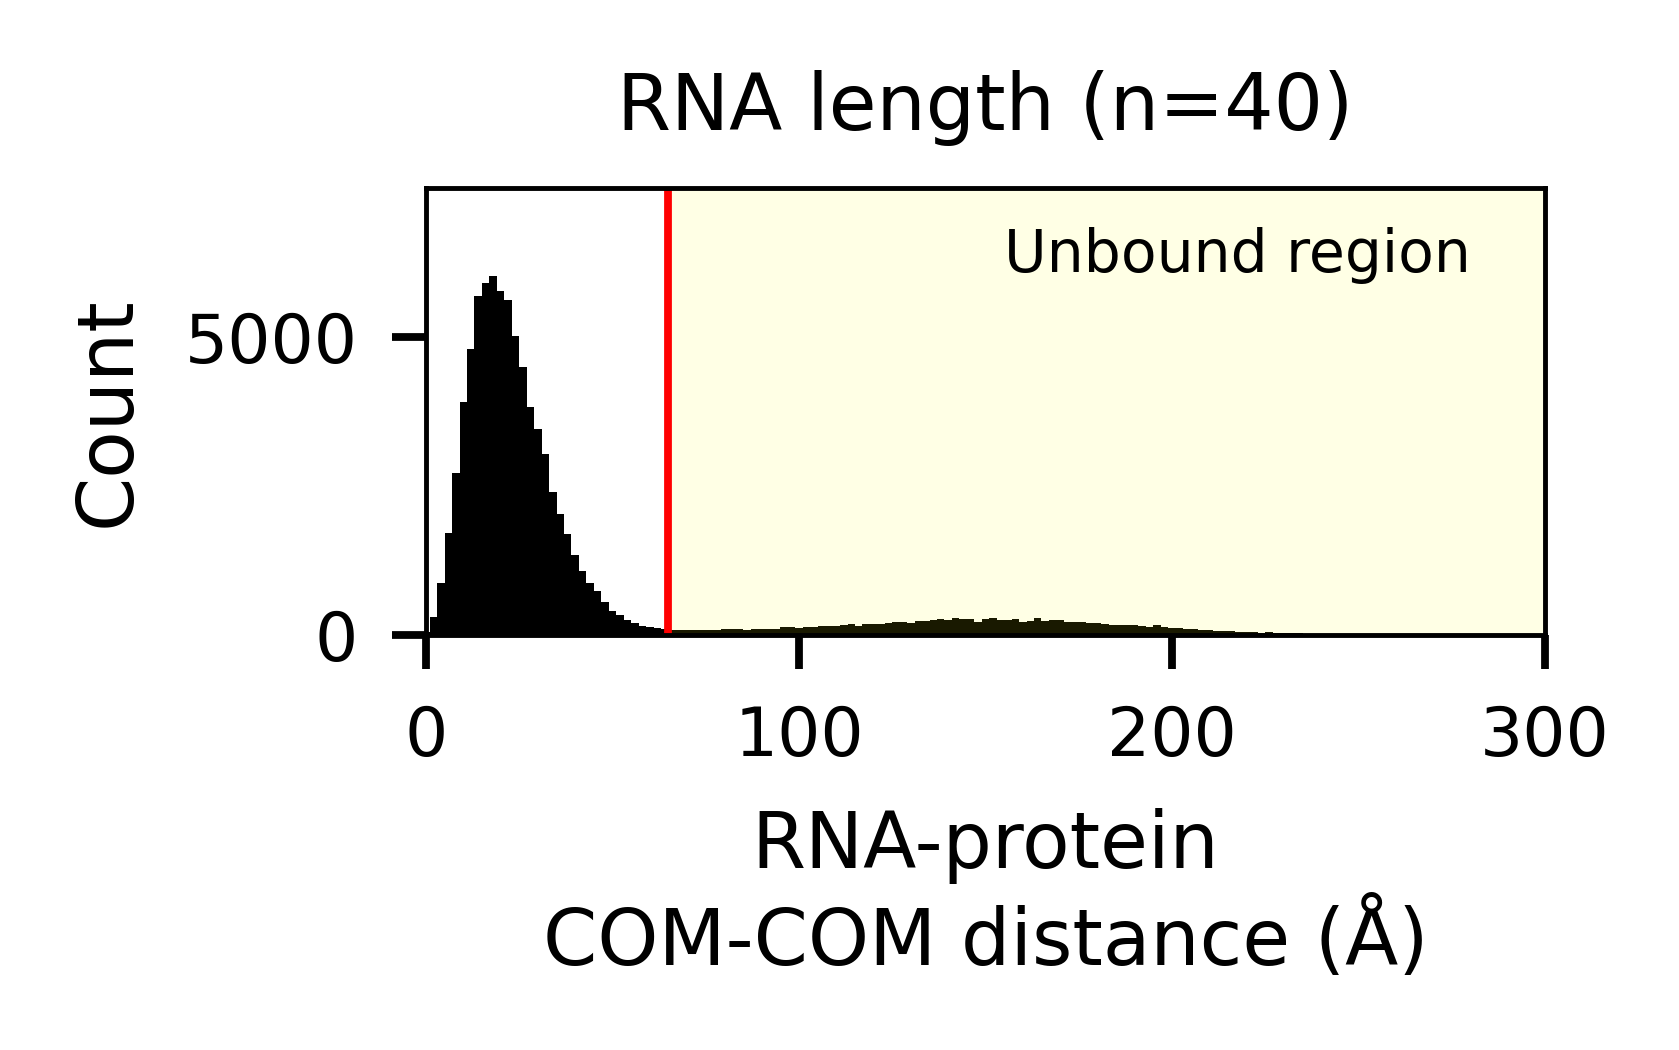

In [21]:
bin_width=2
max_height=7500

for RNA_len in RNA_lengths:
    
    bins = np.arange(0,300+bin_width,bin_width)
    [a,b] = np.histogram(len2COM_distance[RNA_len],bins=bins)
    
    
    figure(None, (2.5,1.6), dpi=350)
    plt.bar(bins[0:-1],a, width=bin_width, color='k')
    plt.plot([len2cutoff[RNA_len],len2cutoff[RNA_len]],[0,max_height], color='r',linewidth=0.8)
    plt.ylim([0,max_height])
    plt.title(f'RNA length (n={RNA_len})',fontsize=8)
    ax = plt.gca()
    ax.axvspan(len2cutoff[RNA_len],300, color='yellow', alpha=0.1,linewidth=0)
    plt.xlim([0,300])
    
    plt.xlabel('RNA-protein\nCOM-COM distance (Å)',fontsize=8)
    plt.ylabel('Count',fontsize=8)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.text(155,6100,'Unbound region',fontsize=6)
    plt.tight_layout()
    plt.savefig(f'figures/binding_histo_{RNA_len}.pdf')
    
    

### Show binding classification along the trajectory
The final cell here lets you visualize what our contigous/cutoff binding classification means for the COM-COM distance between the two molecules. This is good for sanity checking!

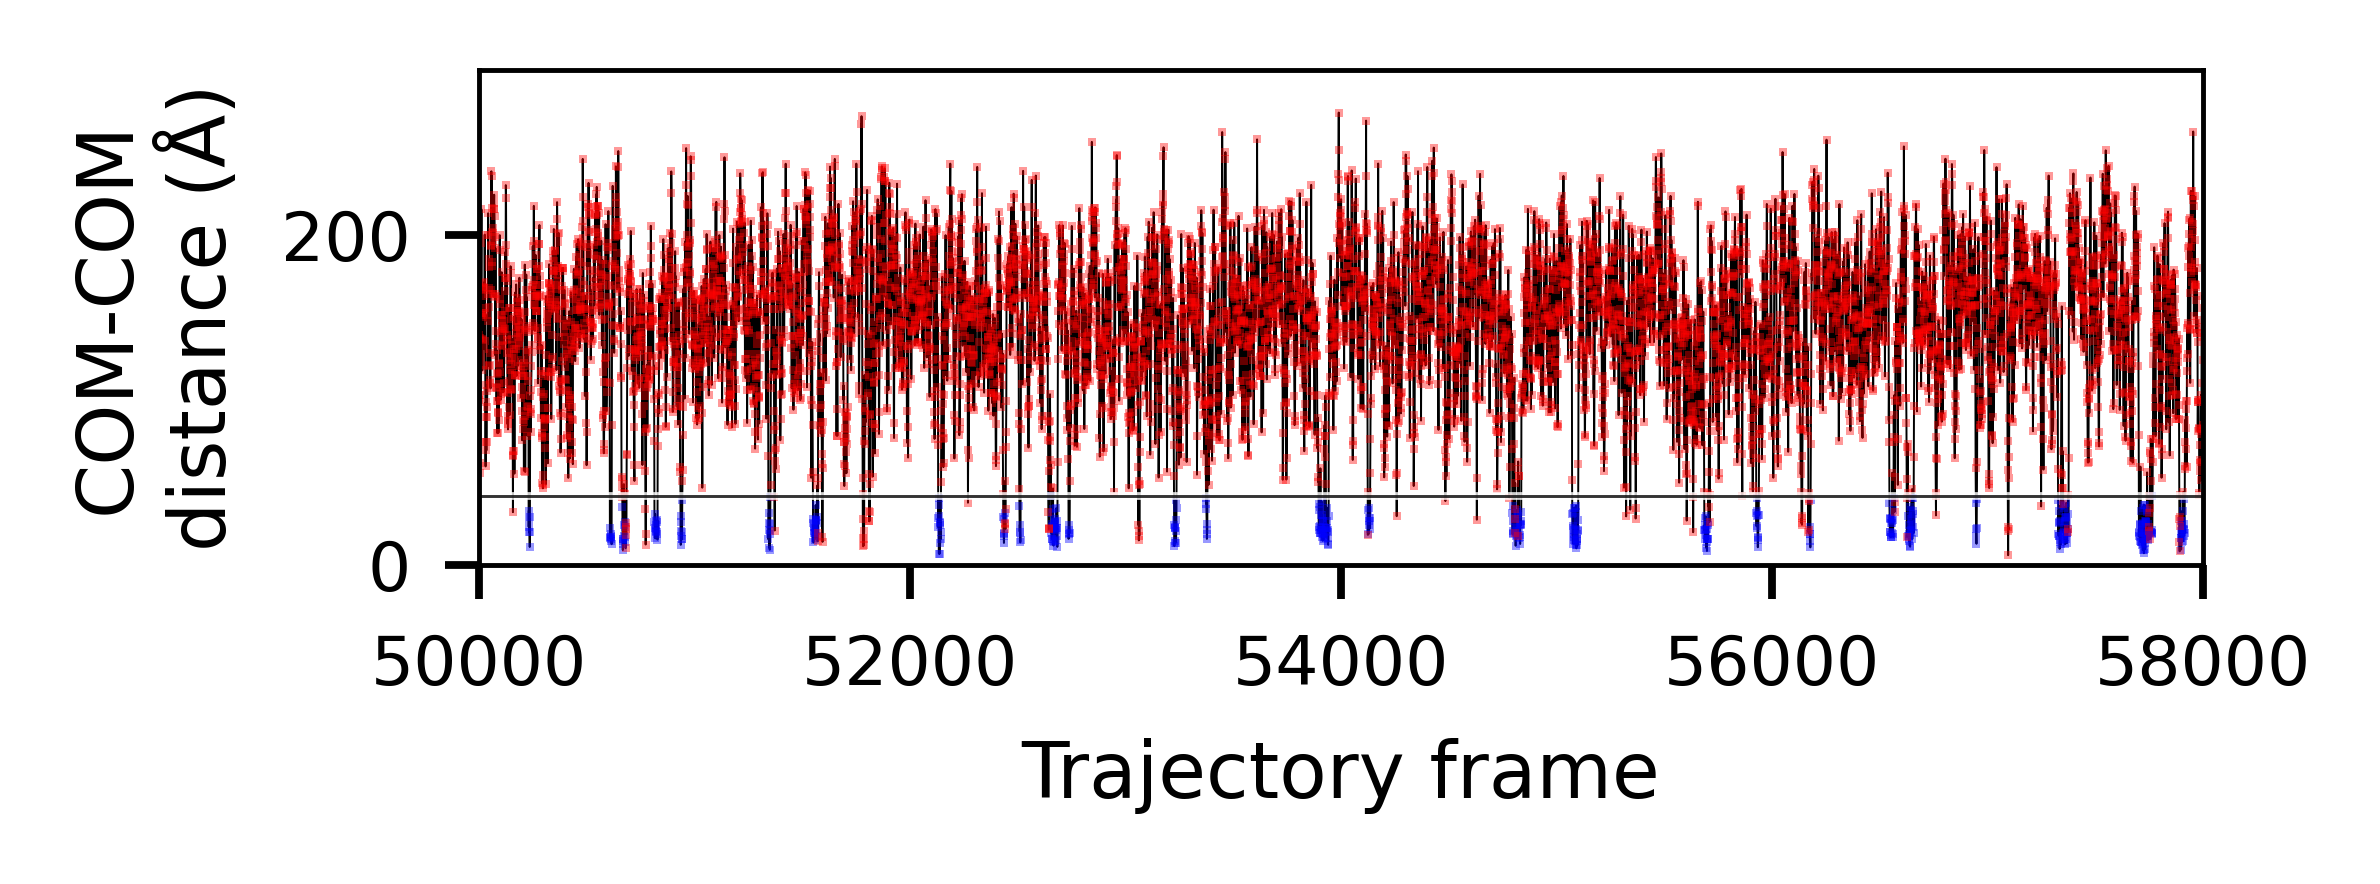

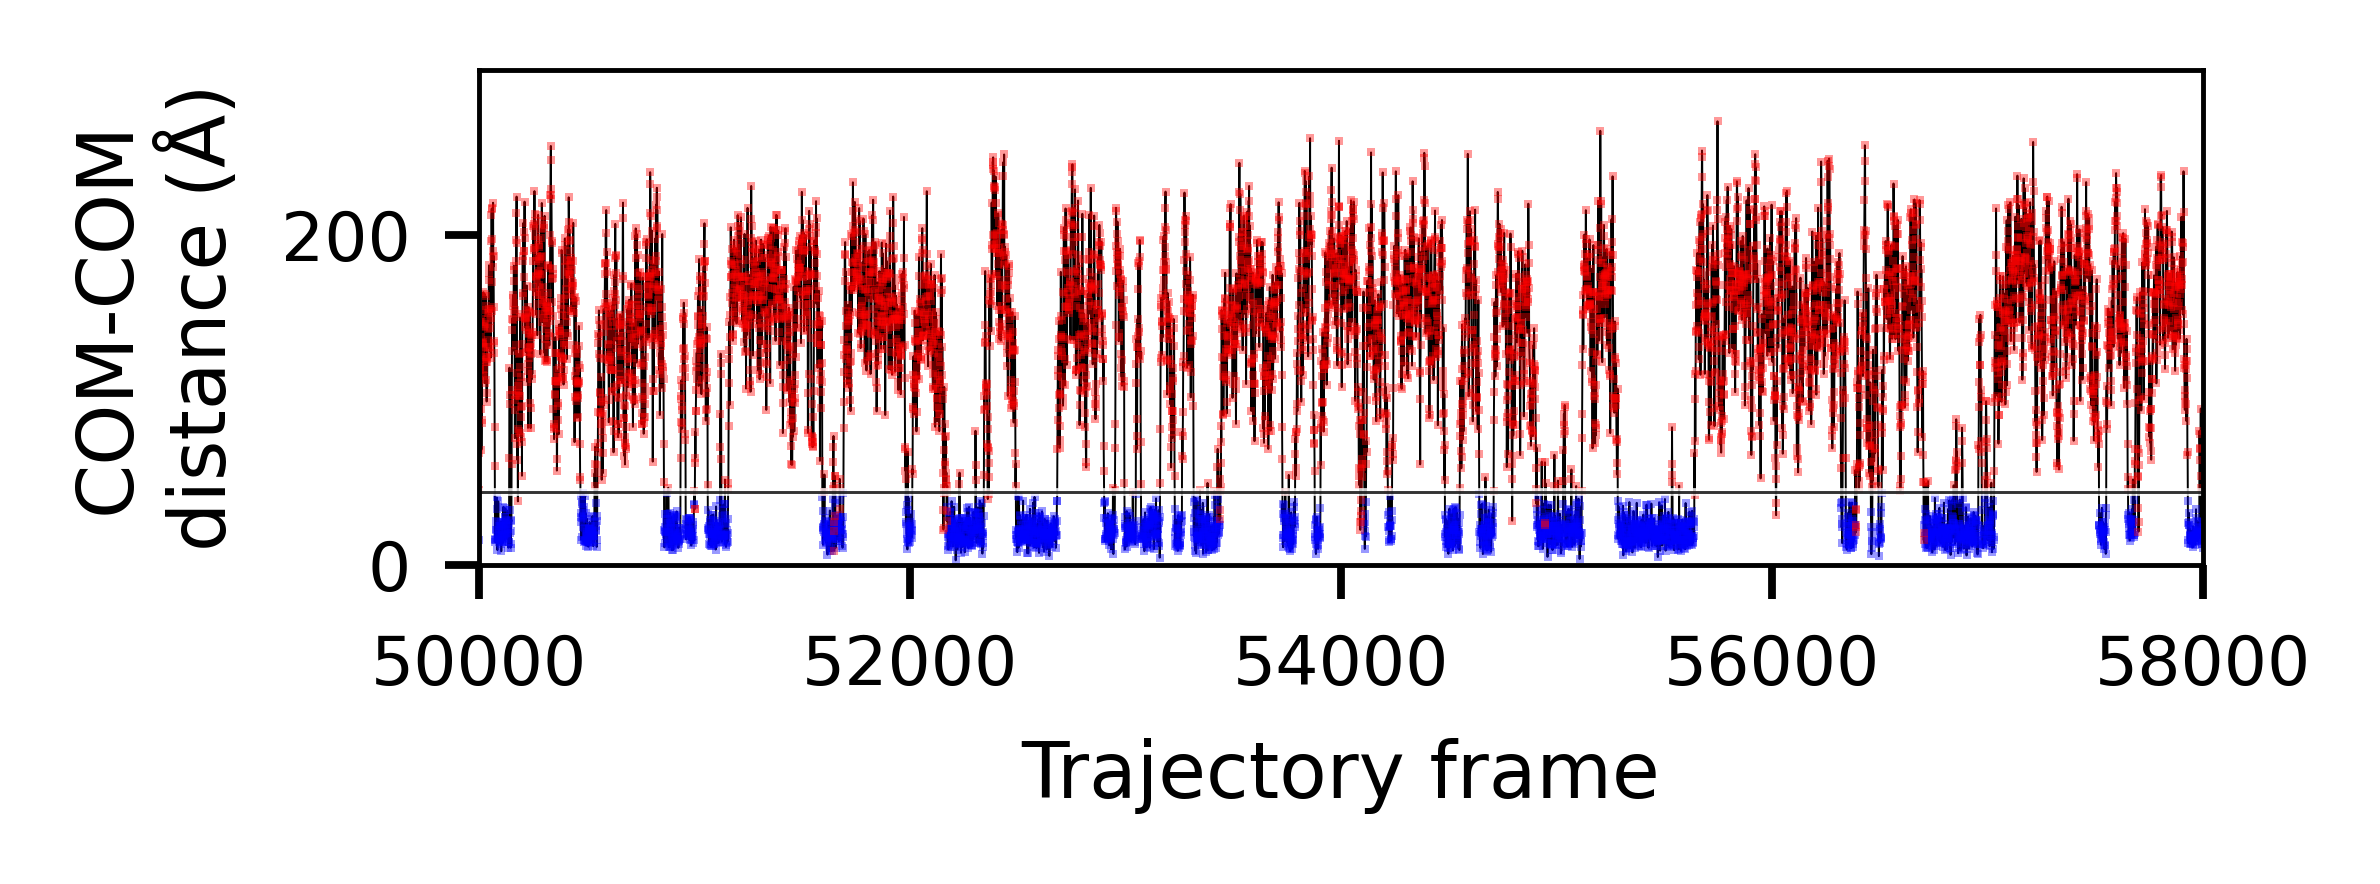

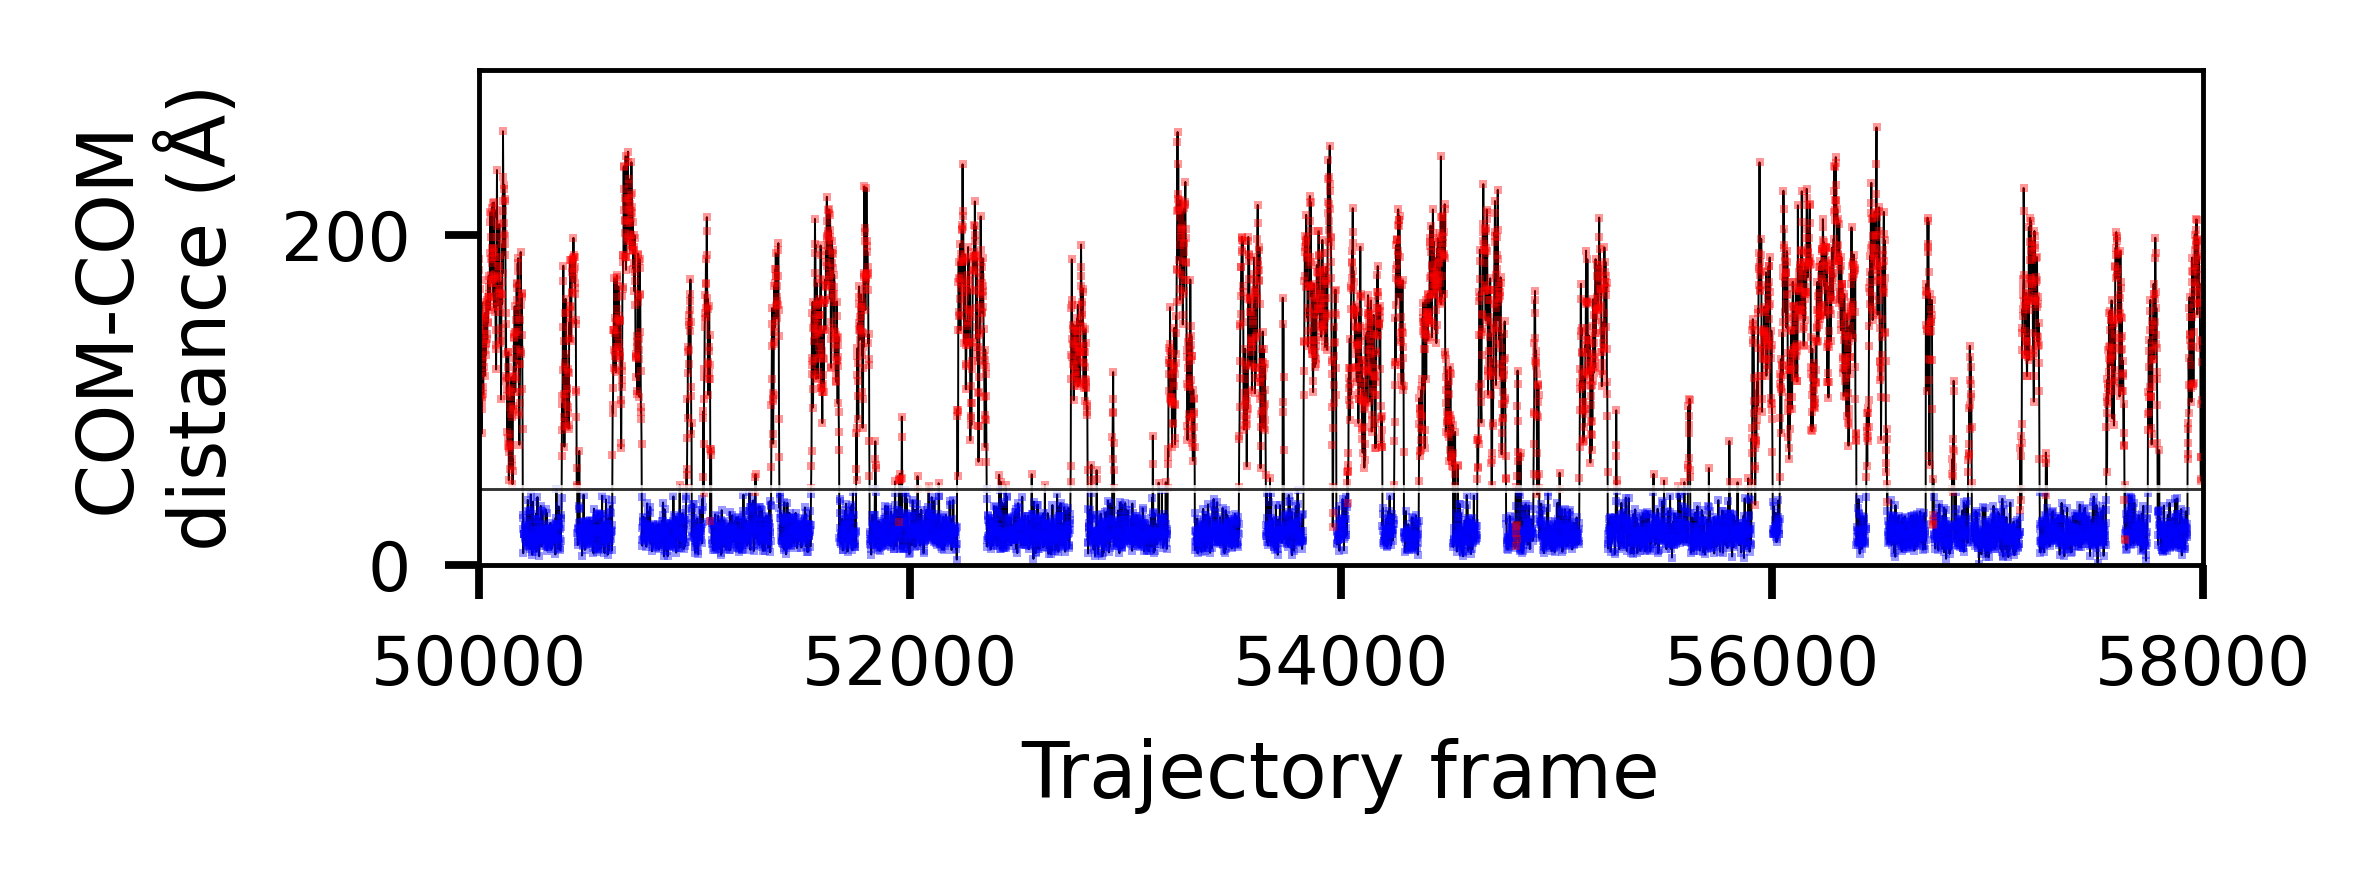

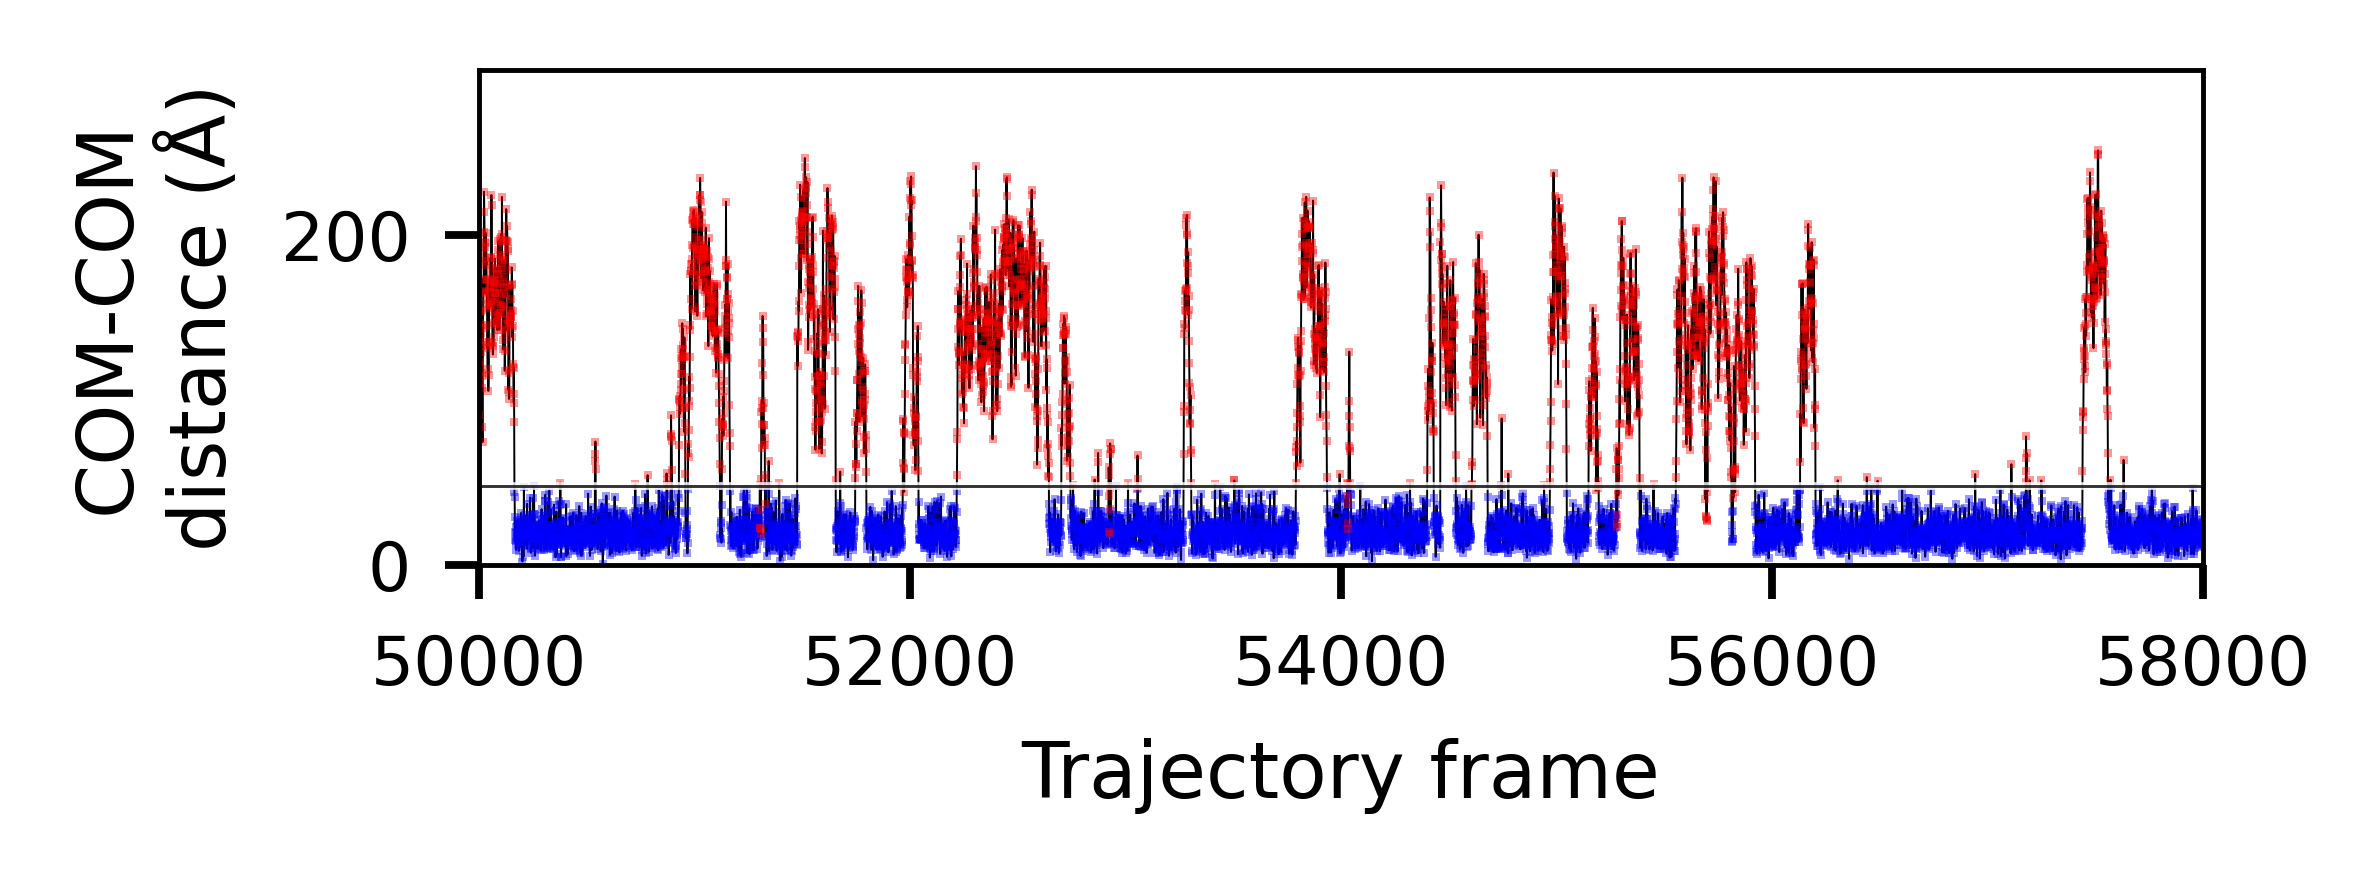

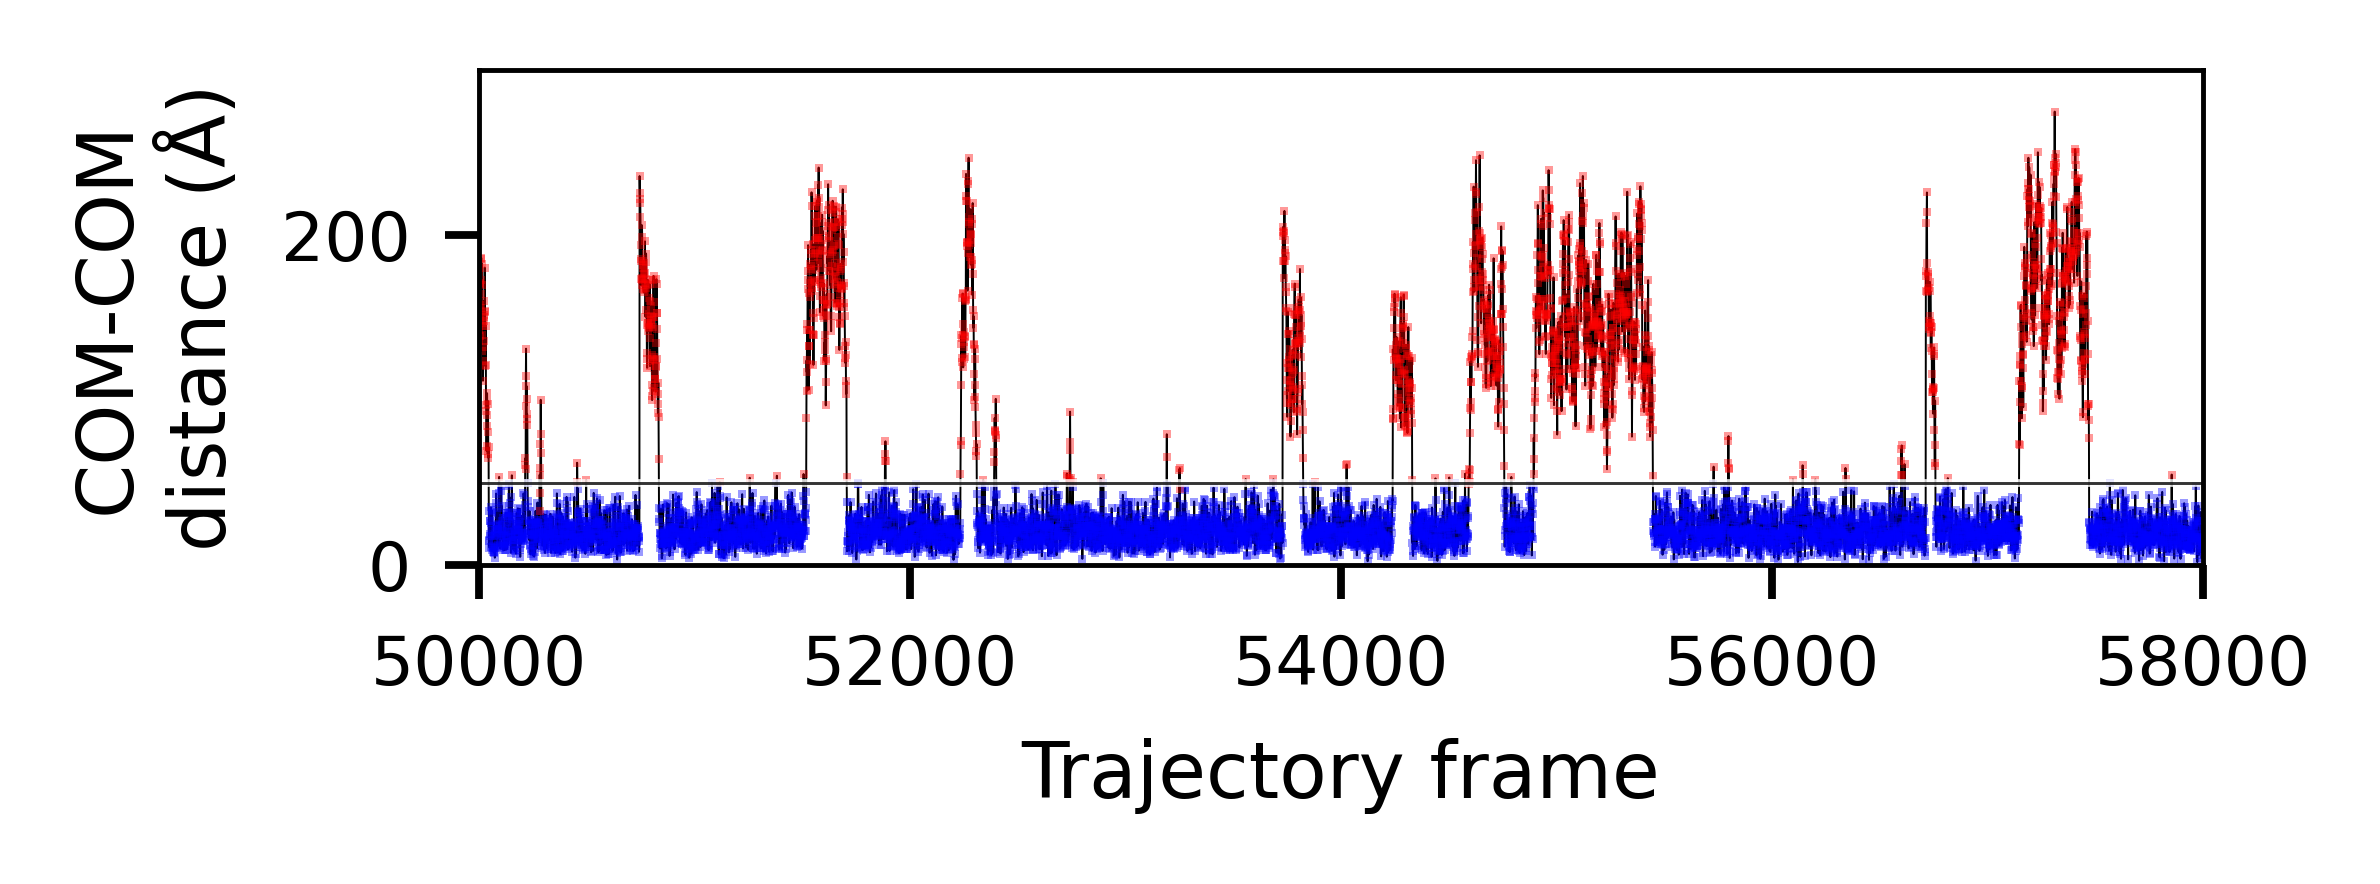

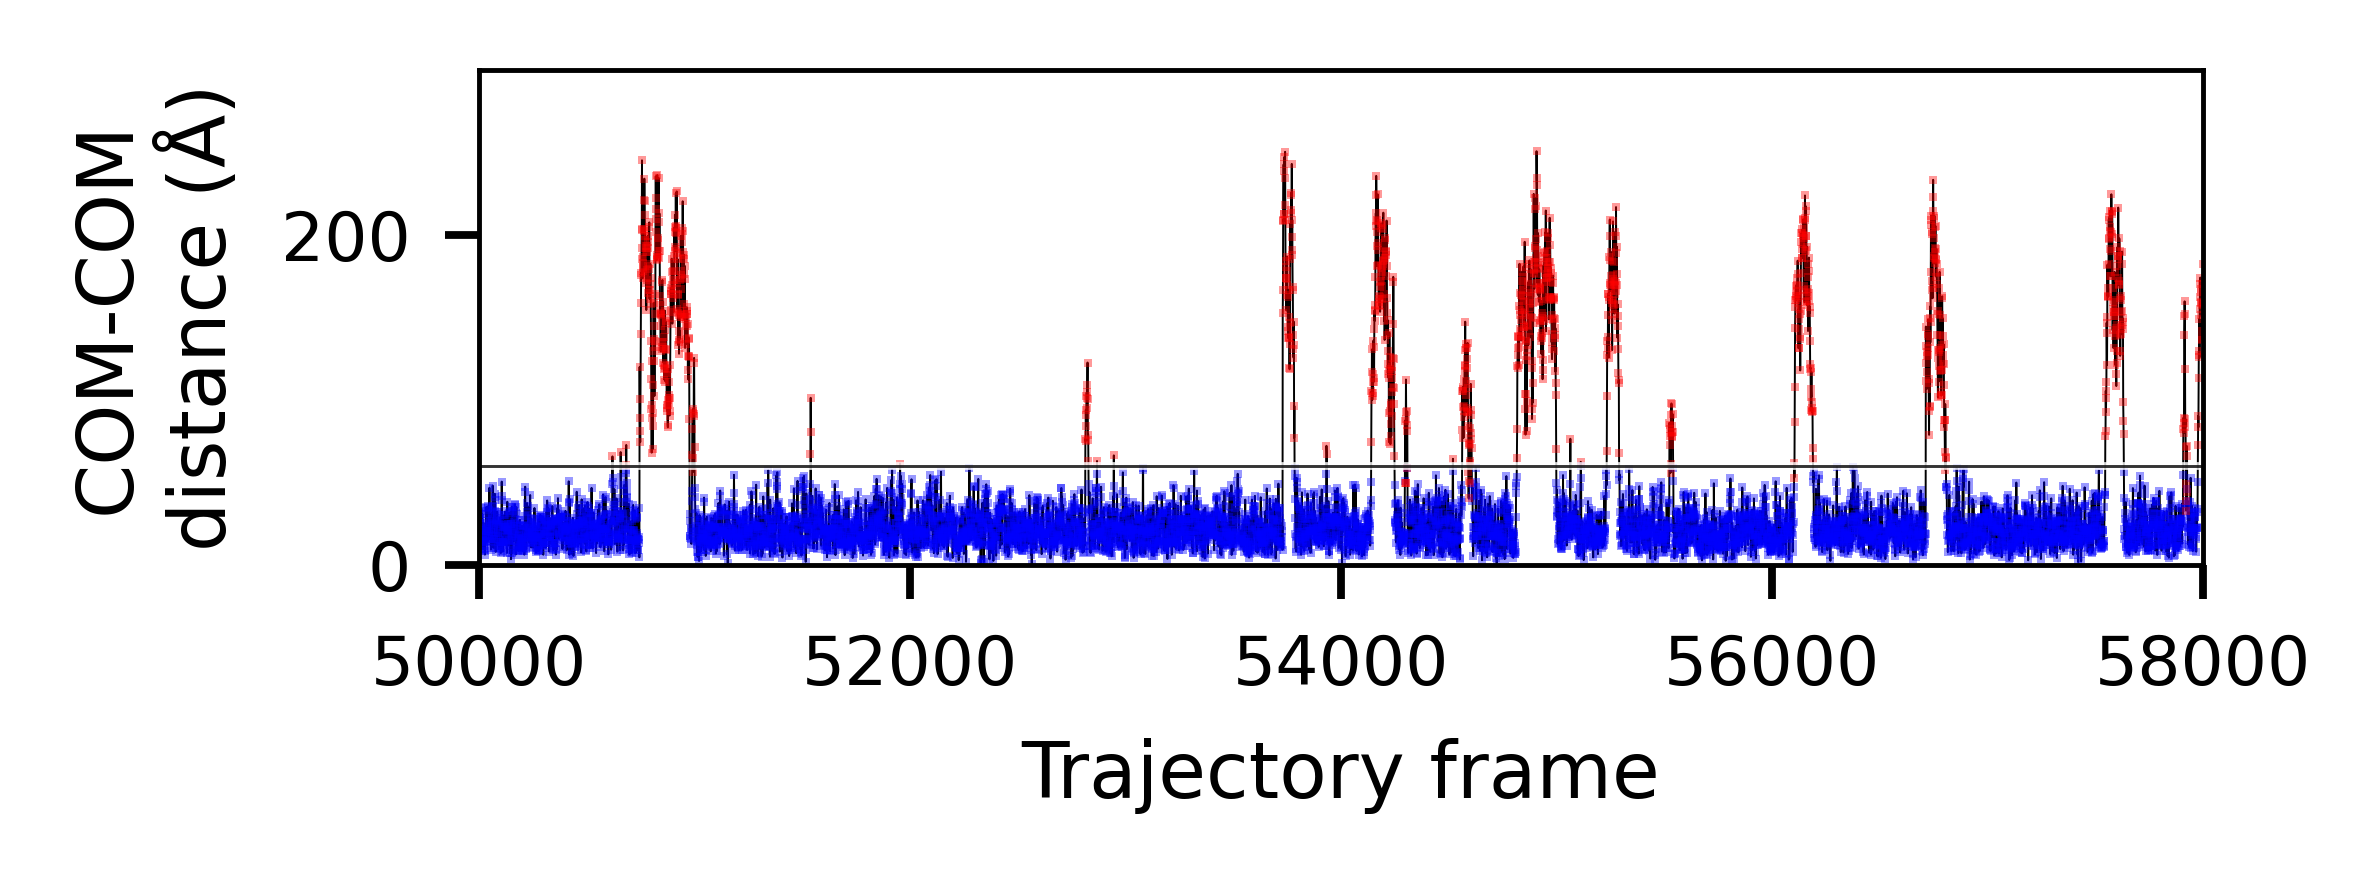

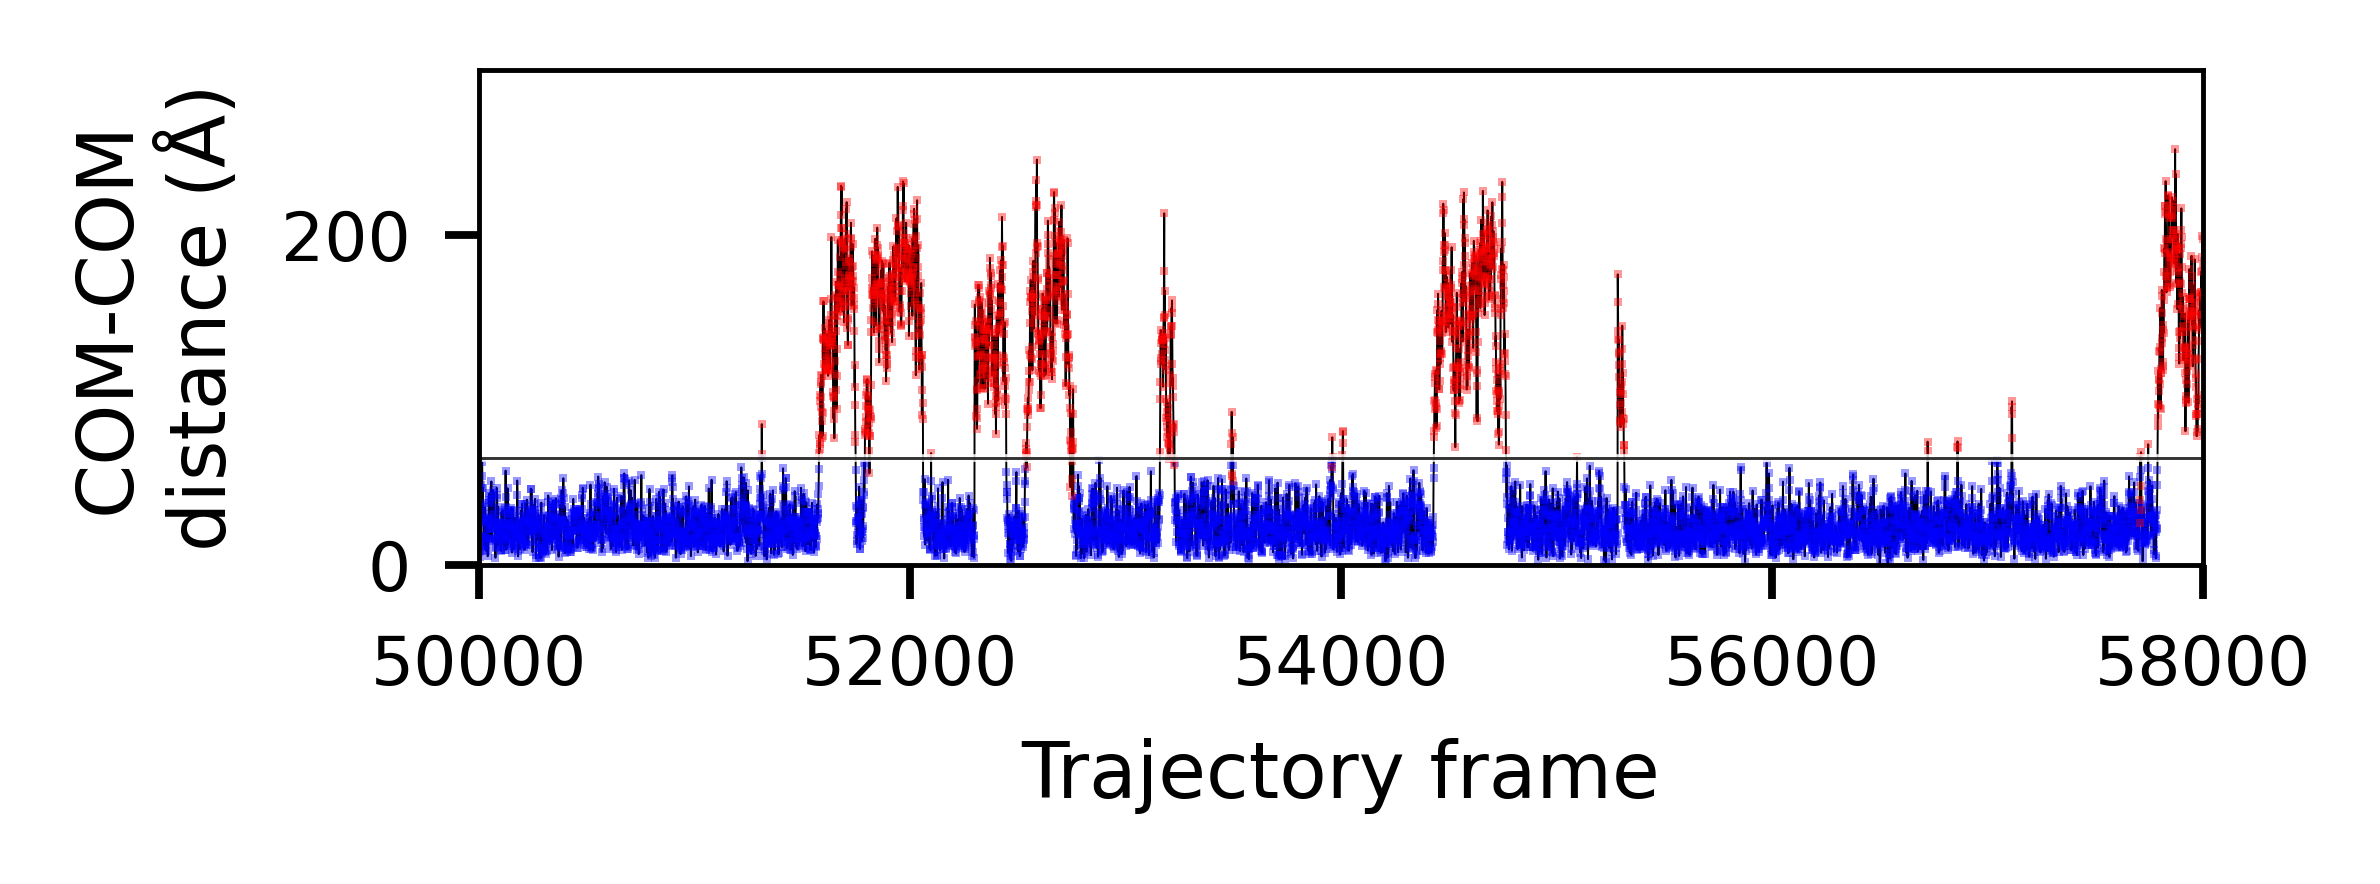

In [28]:
RNA_len=40


for RNA_len in RNA_lengths:

    
    figure(None, (3.5,1.4), dpi=350)

    # plot the fully trajectory
    plt.plot(len2COM_distance[RNA_len],color='k', linewidth=0.2)

    # overlay bound and unbound classifications from the bound_trace output
    plt.plot(len2COM_bound_trace[RNA_len][0], len2COM_bound_trace[RNA_len][1], 's', ms=0.9, mew=0,color='b', label='bound', alpha=0.4)
    plt.plot(len2COM_unbound_trace[RNA_len][0], len2COM_unbound_trace[RNA_len][1], 's',ms=0.9, mew=0,color='r', label='bound', alpha=0.4)

    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    # this draws the RNA length-dependent cutoff line as well, for reference
    plt.plot([0,len(len2COM_distance[RNA_len])], [len2cutoff[RNA_len],len2cutoff[RNA_len]],'-w',linewidth=0.8, alpha=0.8)
    plt.plot([0,len(len2COM_distance[RNA_len])], [len2cutoff[RNA_len],len2cutoff[RNA_len]],'-k',linewidth=0.3, alpha=0.8)

    # this just lets us define start and end regions for a sub-trajectory. 50000 and 60000 are chosen basically
    # randomly...
    b = 50000
    e = 58000
    plt.xlim([b,e])
    plt.ylim([0,300])
    
    plt.ylabel('COM-COM\ndistance (Å)', fontsize=8)
    plt.xlabel('Trajectory frame',fontsize=8)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.tight_layout()
    plt.savefig(f'figures/binding_trace_{RNA_len}.pdf')
    plt.savefig(f'figures/binding_trace_{RNA_len}.png')
    


        

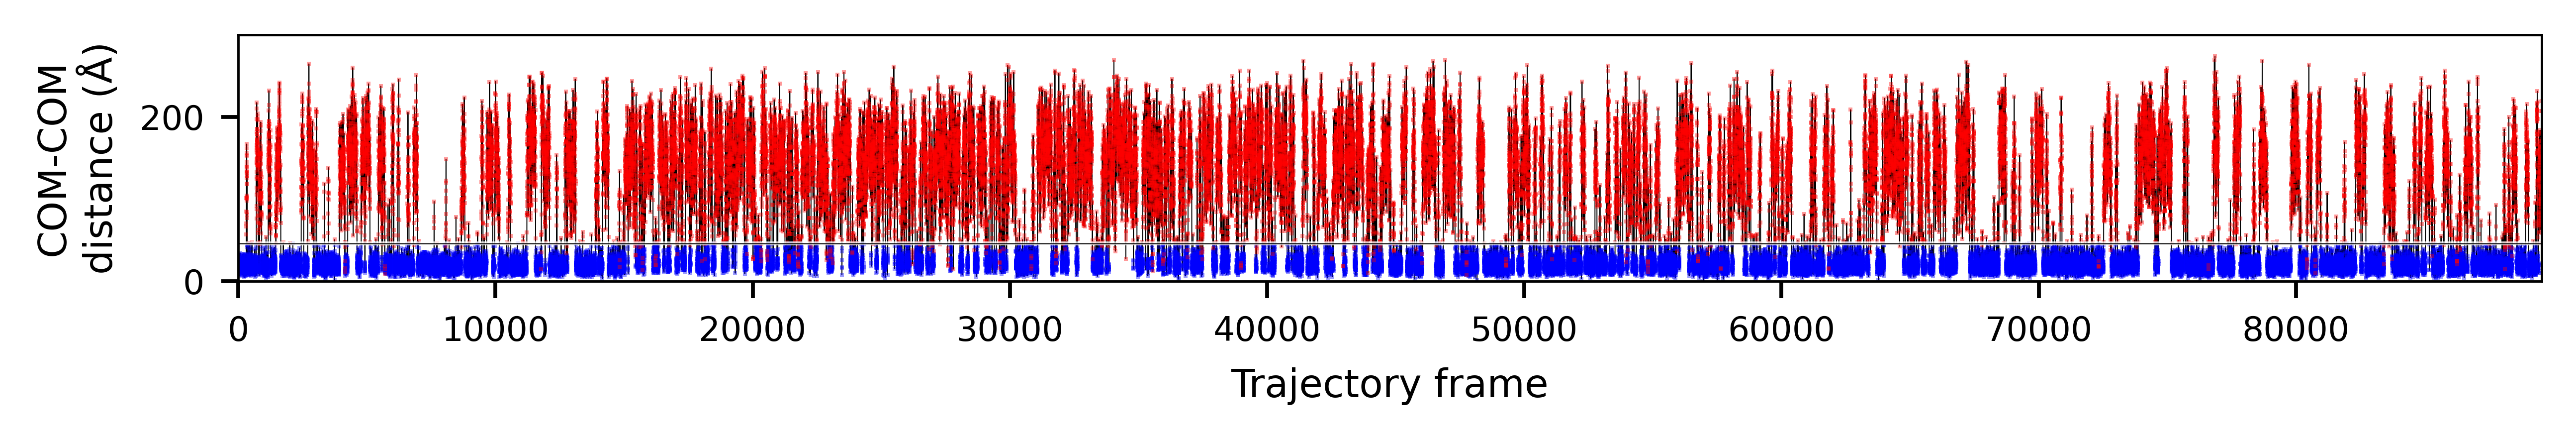

In [27]:

RNA_len=20
figure(None, (7.5,1.4), dpi=350)

# plot the fully trajectory
plt.plot(len2COM_distance[RNA_len],color='k', linewidth=0.2)

# overlay bound and unbound classifications from the bound_trace output
plt.plot(len2COM_bound_trace[RNA_len][0], len2COM_bound_trace[RNA_len][1], 's', ms=0.9, mew=0,color='b', label='bound', alpha=0.4)
plt.plot(len2COM_unbound_trace[RNA_len][0], len2COM_unbound_trace[RNA_len][1], 's',ms=0.9, mew=0,color='r', label='bound', alpha=0.4)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

# this draws the RNA length-dependent cutoff line as well, for reference
plt.plot([0,len(len2COM_distance[RNA_len])], [len2cutoff[RNA_len],len2cutoff[RNA_len]],'-w',linewidth=0.8, alpha=0.8)
plt.plot([0,len(len2COM_distance[RNA_len])], [len2cutoff[RNA_len],len2cutoff[RNA_len]],'-k',linewidth=0.3, alpha=0.8)

# this just lets us define start and end regions for a sub-trajectory. 50000 and 60000 are chosen basically
# randomly...
b = 0
e = len(len2COM_distance[RNA_len])
plt.xlim([b,e])
plt.ylim([0,300])

plt.ylabel('COM-COM\ndistance (Å)', fontsize=8)
plt.xlabel('Trajectory frame',fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.savefig(f'figures/LONG_binding_trace_{RNA_len}.pdf')
plt.savefig(f'figures/LONG_binding_trace_{RNA_len}.png')

In [44]:
n_unbinding_events = []
for RNA_len in RNA_lengths:

    unbinding_events = 0
    for idx, val in enumerate(len2COM_bound_trace[RNA_len][0][:-1]):
        if len2COM_bound_trace[RNA_len][0][idx+1] != val +1:
            unbinding_events = unbinding_events+1
            
    n_unbinding_events.append(unbinding_events)
    

In [45]:
n_unbinding_events

[560, 739, 615, 568, 546, 302, 209]